fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


Outer Loop: 100%|██████████| 100/100 [6:24:59<00:00, 231.00s/it]


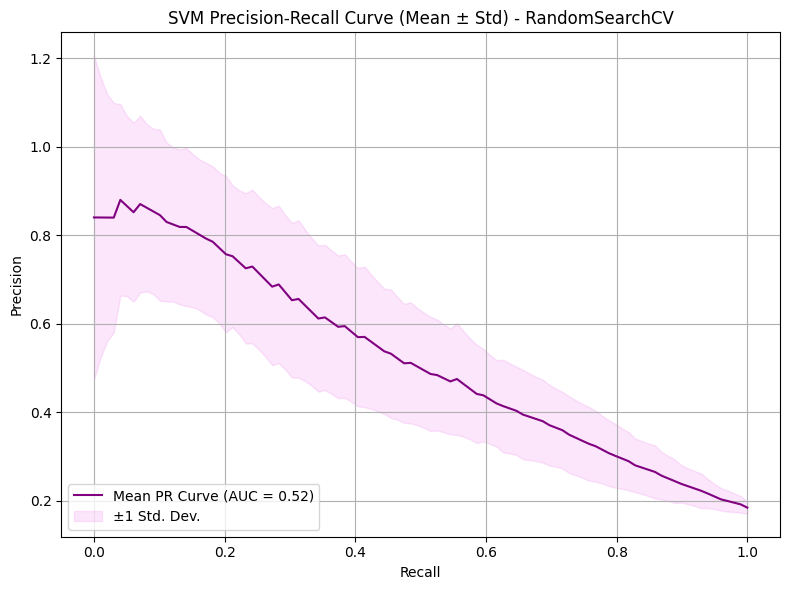

In [3]:
import os
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, accuracy_score,
    f1_score, precision_recall_curve, auc as pr_auc, make_scorer
)
from scipy.stats import loguniform, uniform



# Load data
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

outer = range(100)
best_params_dict = {}
best_model_dict = {}
precision_list = []
recall_list = []
auc_list = []

for outer_rand in tqdm(outer, desc='Outer Loop'):
    X_train_outer, X_test_outer, y_train_outer, y_test_outer = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=outer_rand
    )

    # Apply MinMaxScaler and PCA separately to the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train_outer = scaler.fit_transform(X_train_outer)
    X_test_outer = scaler.transform(X_test_outer)

    pca = PCA(n_components=0.99, random_state=42)
    X_train_outer = pca.fit_transform(X_train_outer)
    X_test_outer = pca.transform(X_test_outer)

    # Define pipeline
    pipeline = Pipeline([
        ('svc', SVC(kernel='rbf', probability=True))
    ])

    # Hyperparameter space for RandomizedSearchCV
    param_grid_svc = {
        'svc__C': loguniform(0.1, 100),               # Regularization strength
        'svc__gamma': loguniform(1e-3, 1),            # Kernel coefficient
        'svc__class_weight': ['balanced', None],
        'svc__shrinking': [True, False],
        'svc__tol': uniform(1e-4, 1e-3)
    }

    cv_inner = StratifiedKFold(n_splits=7, shuffle=True, random_state=7)

    # def pr_auc_score(y_true, y_pred_proba):
    #     precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    #     return pr_auc(recall, precision)

    # pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)
    f1_scorer = make_scorer(f1_score)


    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grid_svc,
        # scoring=pr_auc_scorer,
        scoring=f1_scorer,
        cv=cv_inner,
        n_iter=100,
        n_jobs=-1,
        random_state=7
    )

    random_search.fit(X_train_outer, y_train_outer)

    best_model = random_search.best_estimator_
    best_params = random_search.best_params_

    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)[:, 1]

    tn, fp, fn, tp = confusion_matrix(y_test_outer, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    auc_score = roc_auc_score(y_test_outer, y_pred_proba)
    f1 = f1_score(y_test_outer, y_pred)
    accuracy = accuracy_score(y_test_outer, y_pred)

    precision, recall, _ = precision_recall_curve(y_test_outer, y_pred_proba)
    pr_score = pr_auc(recall, precision)

    best_params_dict[f"Outer {outer_rand}"] = {
        **best_params,
        'auc': auc_score,
        'f1': f1,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'pr_auc': pr_score
    }
    best_model_dict[f"Outer {outer_rand}"] = best_model

    precision_list.append(precision)
    recall_list.append(recall)
    auc_list.append(pr_score)

    # Save best parameters
    results_df = pd.DataFrame.from_dict(best_params_dict, orient='index')
    results_csv_path = os.path.join(os.getcwd(), 'svm_best_hyperparameters_randomsearch.csv')
    results_df.to_csv(results_csv_path)

    # Save PR curve data
    pr_data = {
        "precision_list": precision_list,
        "recall_list": recall_list,
        "auc_list": auc_list
    }
    pr_data_path = os.path.join(os.getcwd(), 'svm_precision_recall_data_randomsearch.pkl')
    with open(pr_data_path, 'wb') as f:
        pickle.dump(pr_data, f)

# Load PR curve data
with open(pr_data_path, 'rb') as f:
    pr_data = pickle.load(f)

precision_list = pr_data["precision_list"]
recall_list = pr_data["recall_list"]
auc_list = pr_data["auc_list"]

mean_recall = np.linspace(0, 1, 100)
interp_precisions = []

for precision, recall in zip(precision_list, recall_list):
    order = np.argsort(recall)
    recall_sorted = recall[order]
    precision_sorted = precision[order]
    interp = np.interp(mean_recall, recall_sorted, precision_sorted, left=1.0, right=0.0)
    interp_precisions.append(interp)

mean_precision = np.mean(interp_precisions, axis=0)
std_precision = np.std(interp_precisions, axis=0)

plt.figure(figsize=(8, 6))
plt.plot(mean_recall, mean_precision, label=f"Mean PR Curve (AUC = {np.mean(auc_list):.2f})", color='purple')
plt.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision,
                 alpha=0.2, color='violet', label="±1 Std. Dev.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM Precision-Recall Curve (Mean ± Std) - RandomSearchCV")
plt.legend(loc="lower left")
plt.grid()
plt.tight_layout()

plot_path = os.path.join(os.getcwd(), 'svm_pr_curve_randomsearch.png')
plt.savefig(plot_path)
plt.show()
